# Importing the usual libraries

In [108]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Getting the page's URL with all the comments regarding HSBC's share price

In [2]:
url='https://uk.advfn.com/stock-market/london/hsbc-HSBA/share-chat?page=0%27xref=chatnav_i_0_t'

In [3]:
r=requests.get(url)

In [4]:
soup=BeautifulSoup(r.text,'html.parser')

In [5]:
results=soup.find_all('tr',attrs={'class':['odd','even']})

In [6]:
first_result=results[3]

# Getting the main data points for sentiment analysis (Date & Comments)

In [8]:
#Date & Time
first_result.find('td',attrs={'style':"vertical-align:top"}).text

'22/6/202018:23'

In [9]:
#Comment
first_result.find('a',attrs={'class':"msgStyle"}).text

"That's also my view essentially - swing trade, hold some as an investment.\n\nStarted OK, been in and out a few times already, but against the background of a wider market recovery, it remains a dog. So far."

# Scrapping all the existing pages on the forum to retrieve data up until the early 2000's

In [46]:
records=[]
pages=np.arange(0,388)

for page in pages:

    page='https://uk.advfn.com/stock-market/london/hsbc-HSBA/share-chat?page='+str(page)+'xref=chatnav_i_0_t'
    r=requests.get(page)
    soup=BeautifulSoup(r.text,'html.parser')
    results=soup.find_all('tr',attrs={'class':['odd','even']})
    first_result=results[3]

    for result in results:
        date=result.find('td',attrs={'style':"vertical-align:top"}).text if result.find('td',attrs={'style':"vertical-align:top"}) else ''
        comments=result.find('a',attrs={'class':"msgStyle"}).text if result.find('a',attrs={'class':"msgStyle"}) else ''
        records.append((date,comments)) 

# Putting them all in a dataframe

In [47]:
results=pd.DataFrame(records)

In [48]:
df=results.rename(columns={0:'Date',1:'Comment'})

In [49]:
df

,Date,Comment
0,,
1,,
2,,
3,22/6/202018:23,"That's also my view essentially - swing trade,..."
4,22/6/202018:15,In terms of tier 1 ratio and market cap right ...
...,...,...
9984,18/6/202014:45,"If you must use a historic EPS, then the answe..."
9985,18/6/202014:40,So which one is it? If you look on Google its 12.
9986,18/6/202013:50,Right. I'll leave it there.
9987,18/6/202013:42,Pe does matter.


# Data Cleaning

There's going to be quite some data cleaning needed starting with extracting date and time from the 'Date' column and then converting the date column into a pandas format

In [52]:
df['Time']=df['Date'].str[-5:]

In [64]:
df['Date']=df['Date'].str[:-5]

In [66]:
df['Date']=pd.to_datetime(df['Date'], errors = 'coerce')

In [67]:
df

,Date,Comment,Time
0,NaT,,
1,NaT,,
2,NaT,,
3,2020-06-22,"That's also my view essentially - swing trade,...",18:23
4,2020-06-22,In terms of tier 1 ratio and market cap right ...,18:15
...,...,...,...
9984,2020-06-18,"If you must use a historic EPS, then the answe...",14:45
9985,2020-06-18,So which one is it? If you look on Google its 12.,14:40
9986,2020-06-18,Right. I'll leave it there.,13:50
9987,2020-06-18,Pe does matter.,13:42


In [69]:
df=df.sort_values(by='Date',ascending=True)

Extract the year from the date column

In [70]:
df['Year']=df['Date'].dt.year

Doing the same for the month column

In [71]:
df['Month']=df['Date'].dt.month

Removing the empty rows 

In [74]:
df=df.dropna(axis=0,how='any')

Getting the length of each comment 

In [76]:
df['Comment Length']=df['Comment'].apply(len)


C:\Users\Gwenn\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# EDA

Text(0.5, 1.0, 'Number of comments by year')

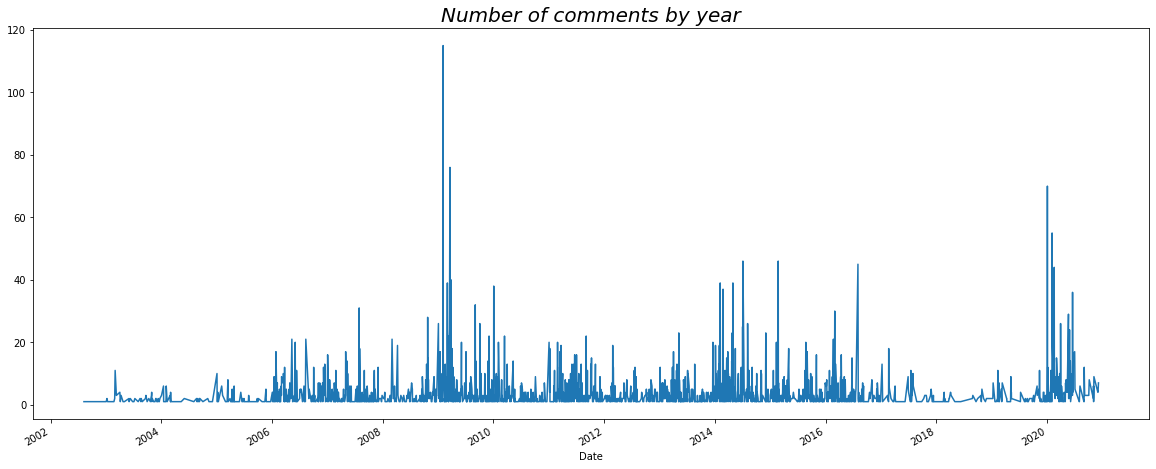

In [77]:
plt.figure(figsize=(20,8))
df.groupby('Date').count()['Comment'].plot()
plt.title('Number of comments by year',fontsize=20,fontstyle='italic')

Text(0.5, 1.0, 'Length of comments by year')

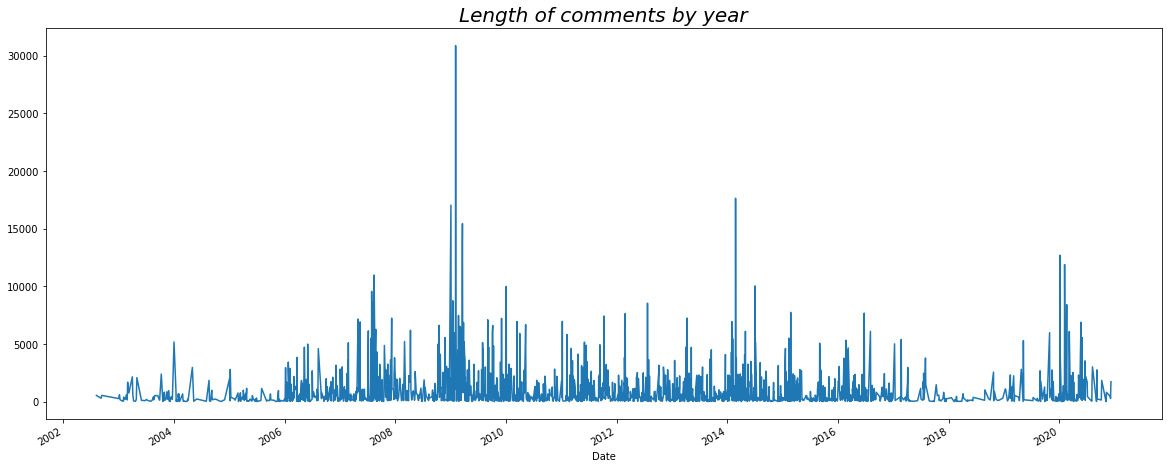

In [78]:
plt.figure(figsize=(20,8))
df.groupby('Date').sum()['Comment Length'].plot()
plt.title('Length of comments by year',fontsize=20,fontstyle='italic')

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text xticklabel objects>)

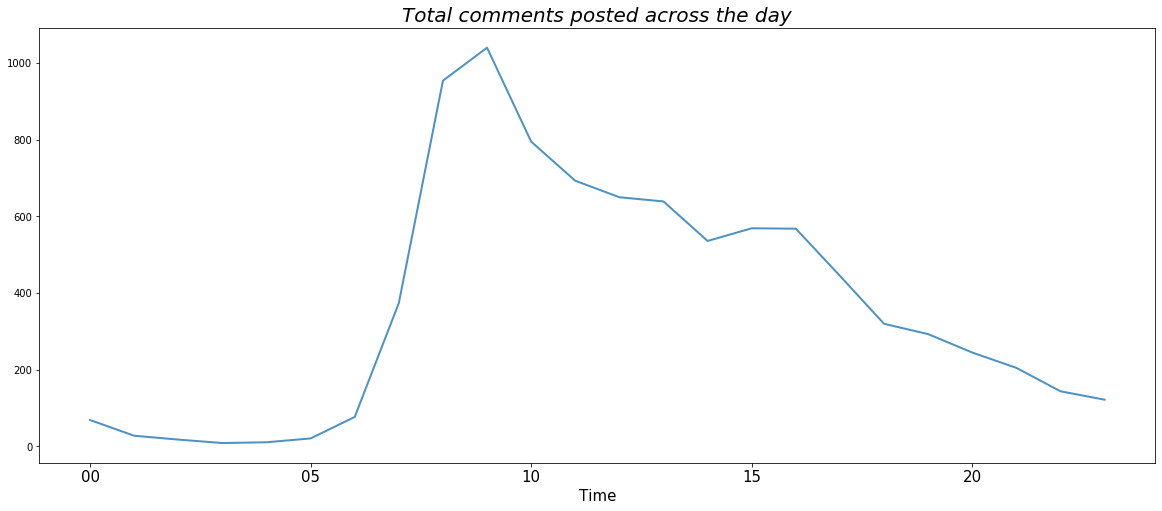

In [142]:
plt.figure(figsize=(20,8))
df.groupby(df['Time'].str[:-3]).count()['Comment'].plot(linewidth=2,alpha=0.8)
plt.title('Total comments posted across the day',fontsize=20,fontstyle='italic')
plt.xlabel('Time',fontsize=15)
plt.xticks(fontsize=15)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 9 Text xticklabel objects>)

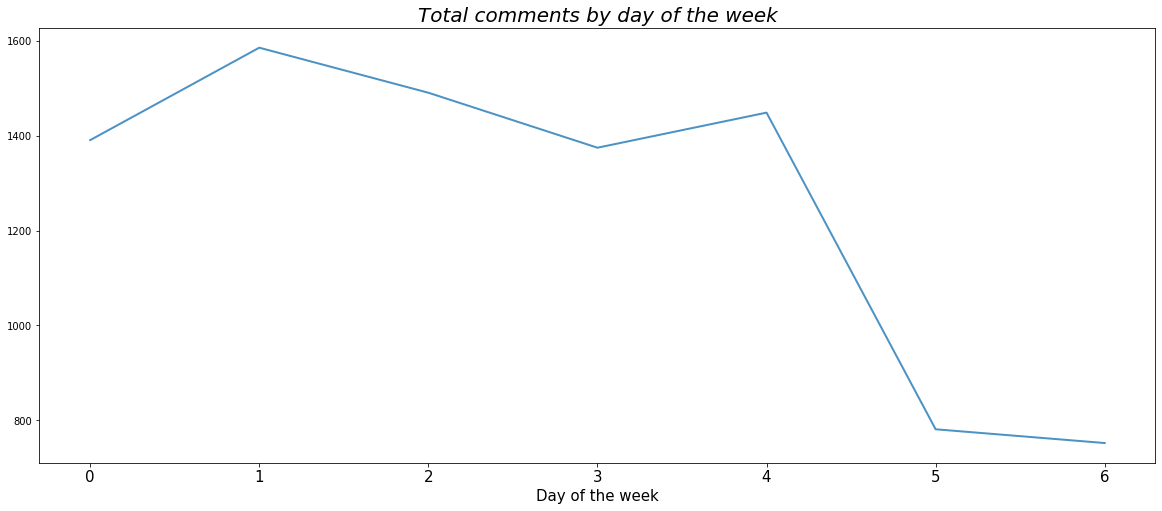

In [152]:
plt.figure(figsize=(20,8))
df.groupby(df['Date'].dt.weekday).count()['Comment'].plot(linewidth=2,alpha=0.8)
plt.title('Total comments by day of the week',fontsize=20,fontstyle='italic')
plt.xlabel('Day of the week',fontsize=15)
plt.xticks(fontsize=15)

In [79]:
comments_by_month=df.groupby('Month').count()['Comment'].reset_index()


In [80]:
comments_by_month=pd.pivot_table(comments_by_month,columns='Month',values='Comment')

In [81]:
comments_by_month

Month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Comment,950,1118,1303,785,686,665,650,559,527,607,499,476


In [82]:
palette = sns.diverging_palette(220, 20, n=256)

(array([0.5]), <a list of 1 Text yticklabel objects>)

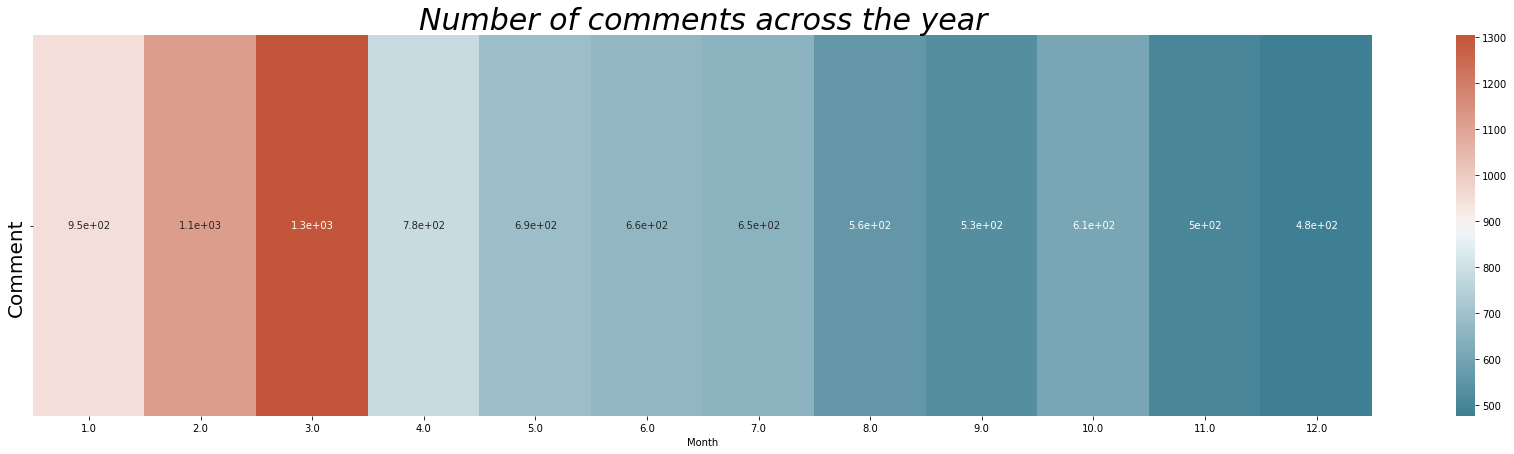

In [83]:
plt.figure(figsize=(30,7))
sns.heatmap(comments_by_month,annot=True,cmap=palette)
plt.title('Number of comments across the year',fontsize=30,fontstyle='italic')
plt.yticks(fontsize=20)

# Let's try to get the sentiment of each comment with the help of word tokenizer, lemmatization and sentiment intensity analyzer

In [94]:
df=df.reset_index()

In [109]:
corpus = []
for i in range(0, 8825):
    review = re.sub('[^a-zA-Z]', ' ', df['Comment'][i])
    review = review.lower()
    review = word_tokenize(review, "english")
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    for word in review:
        word = WordNetLemmatizer().lemmatize(word)
    review = ' '.join(review)
    corpus.append(review)

In [110]:
df['Modified Comment']=corpus

In [111]:
def sentiment_analyser(sentiment_text):
    score=SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    if score['pos']<score['neg']:
        return 'Negative Sentiment'
    elif score['pos']>score['neg']:
        return 'Positive Sentiment'
    else:
        return 'Neutral Sentiment'

In [112]:
df['Sentiment']=df['Modified Comment'].apply(lambda x:sentiment_analyser(x))
df['Sentiment']=df['Sentiment'].astype(str)

Text(0.5, 1.0, 'Overall sentiment about HSBC')

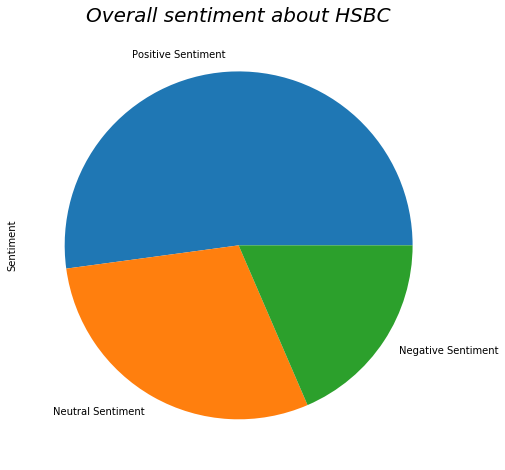

In [114]:
plt.figure(figsize=(8,8))
df['Sentiment'].value_counts(normalize=True).plot.pie()
plt.title('Overall sentiment about HSBC',fontsize=20,fontstyle='italic')

In [115]:
sentiment_by_year=df.groupby(['Year','Sentiment']).count()['Comment'].reset_index()

Text(0.5, 1.0, 'Sentiment by year')

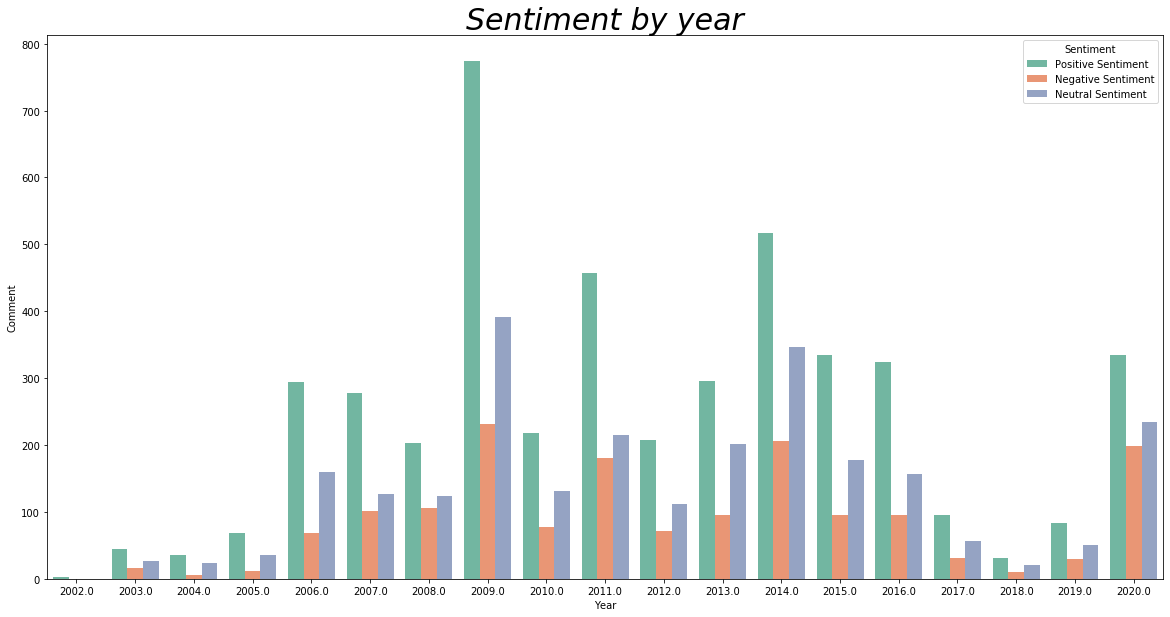

In [116]:
plt.figure(figsize=(20,10))
sns.barplot(x='Year',y='Comment',hue='Sentiment',data=sentiment_by_year,palette='Set2')
plt.title('Sentiment by year',fontsize=30,fontstyle='italic')